In [4]:
import pandas as pd

# Use the path of the uploaded CSV file
file_path = excel_path

# Read the CSV file directly into a DataFrame
df = pd.read_csv(file_path)

print(df.shape)
df.head()

(1067371, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [2]:
from google.colab import files

uploaded = files.upload()

for filename in uploaded.keys():
  print(f'User uploaded file "{filename}" with length {len(uploaded[filename])} bytes')

excel_path = list(uploaded.keys())[0]

Saving online_retail_II.csv to online_retail_II.csv
User uploaded file "online_retail_II.csv" with length 94850204 bytes


In [9]:
df = df.dropna(subset=["Invoice", "InvoiceDate", "Customer ID"]).copy()
df["Customer ID"] = df["Customer ID"].astype(str)

In [11]:
df = df[~df["Invoice"].astype(str).str.startswith("C")]

In [12]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
df = df.dropna(subset=["InvoiceDate"])


/tmp/ipython-input-712451272.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")


In [19]:
df = df[(df["Quantity"] > 0) & (df["Price"] > 0)].copy()

In [16]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

/tmp/ipython-input-723398808.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["TotalPrice"] = df["Quantity"] * df["Price"]


In [17]:
analysis_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)
analysis_date


Timestamp('2011-12-10 12:50:00')

In [21]:
rfm = df.groupby("Customer ID").agg(
    Recency=("InvoiceDate", lambda x: (analysis_date - x.max()).days),
    Frequency=("Invoice", "nunique"),
    Monetary=("TotalPrice", "sum")
).reset_index()

rfm.head()

,Customer ID,Recency,Frequency,Monetary
0,12346.0,326,12,77556.46
1,12347.0,2,8,5633.32
2,12348.0,75,5,2019.40
3,12349.0,19,4,4428.69
4,12350.0,310,1,334.40


In [22]:
import numpy as np

def safe_qcut(series, q, labels):
    series_rank = series.rank(method="first")
    return pd.qcut(series_rank, q=q, labels=labels)

rfm["R_Score"] = safe_qcut(rfm["Recency"], 5, labels=[5,4,3,2,1]).astype(int)
rfm["F_Score"] = safe_qcut(rfm["Frequency"], 5, labels=[1,2,3,4,5]).astype(int)
rfm["M_Score"] = safe_qcut(rfm["Monetary"], 5, labels=[1,2,3,4,5]).astype(int)

rfm["RFM_Score"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)
rfm.head()


,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,12346.0,326,12,77556.46,2,5,5,255
1,12347.0,2,8,5633.32,5,4,5,545
2,12348.0,75,5,2019.40,3,4,4,344
3,12349.0,19,4,4428.69,5,3,5,535
4,12350.0,310,1,334.40,2,1,2,212


In [23]:
def segment_customer(row):
    r, f, m = row["R_Score"], row["F_Score"], row["M_Score"]

    if r >= 4 and f >= 4 and m >= 4:
        return "Champions"
    if f >= 4 and r >= 3:
        return "Loyal Customers"
    if m >= 4 and f >= 3:
        return "Big Spenders"
    if r >= 4 and f <= 2:
        return "New Customers"
    if r >= 3 and f == 3:
        return "Potential Loyalists"
    if r <= 2 and f >= 3:
        return "At Risk"
    if r <= 2 and f <= 2:
        return "Hibernating"
    return "Others"

rfm["Segment"] = rfm.apply(segment_customer, axis=1)
rfm["Segment"].value_counts()


,count
Segment,
Hibernating,1526
Champions,1292
Loyal Customers,705
Big Spenders,528
Potential Loyalists,510
At Risk,492
New Customers,441
Others,384


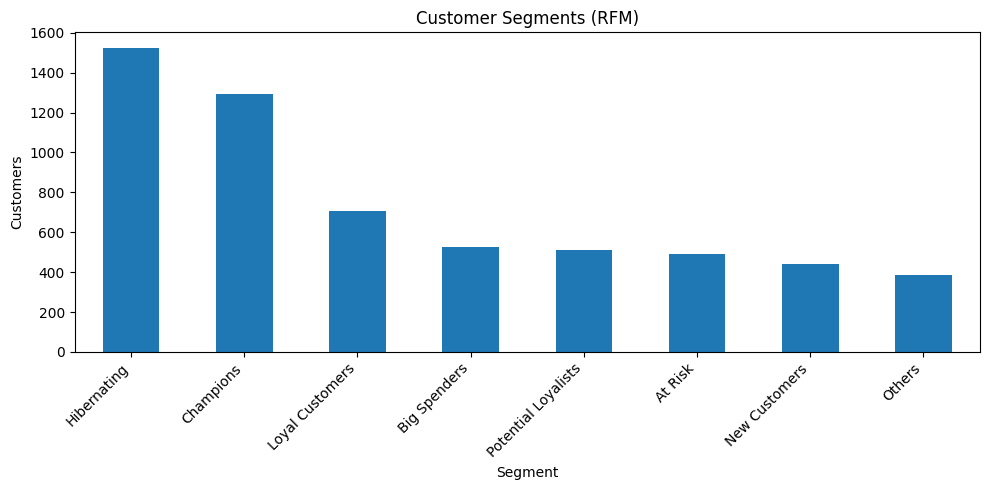

In [24]:
import matplotlib.pyplot as plt

seg_counts = rfm["Segment"].value_counts()

plt.figure(figsize=(10,5))
seg_counts.plot(kind="bar")
plt.title("Customer Segments (RFM)")
plt.xlabel("Segment")
plt.ylabel("Customers")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [25]:
rfm.to_csv("rfm_segments.csv", index=False)
print("Saved rfm_segments.csv ✅")


Saved rfm_segments.csv ✅
